# QRT ENS Data Challenge 2023 - Benchmark

This notebook details the benchmark construction for the challenge - it may also help participants to start the competition.

## Libraries

In [30]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [31]:
import seaborn as sns

## Loading data

- `X_train` and `X_test` both have $35$ columns that represent the same explanatory variables but over different time periods. 

- `X_train` and `Y_train` share the same column `ID` - each row corresponds to a unique ID associated with a day and a country. 

- The target of this challenge `TARGET` in `Y_train` corresponds to the price change for daily futures contracts of 24H electricity baseload. 

- **You will notice some columns have missing values**.


In [32]:
# After downloading the X_train/X_test/Y_train .csv files in your working directory:

X_train = pd.read_csv('X_train.csv')
Y_train = pd.read_csv('Y_train.csv')
X_test = pd.read_csv('X_test.csv')

In [33]:
X_train.head()

,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
0,1054,206,FR,0.210099,-0.427458,-0.606523,0.606523,NaN,0.692860,NaN,...,-0.444661,-0.172680,-0.556356,-0.790823,-0.283160,-1.069070,-0.063404,0.339041,0.124552,-0.002445
1,2049,501,FR,-0.022399,-1.003452,-0.022063,0.022063,-0.573520,-1.130838,0.573520,...,-1.183194,-1.240300,-0.770457,1.522331,0.828412,0.437419,1.831241,-0.659091,0.047114,-0.490365
2,1924,687,FR,1.395035,1.978665,1.021305,-1.021305,-0.622021,-1.682587,0.622021,...,1.947273,-0.480700,-0.313338,0.431134,0.487608,0.684884,0.114836,0.535974,0.743338,0.204952
3,297,720,DE,-0.983324,-0.849198,-0.839586,0.839586,-0.270870,0.563230,0.270870,...,-0.976974,-1.114838,-0.507570,-0.499409,-0.236249,0.350938,-0.417514,0.911652,-0.296168,1.073948
4,1101,818,FR,0.143807,-0.617038,-0.924990,0.924990,NaN,0.990324,NaN,...,-0.526267,-0.541465,-0.424550,-1.088158,-1.011560,0.614338,0.729495,0.245109,1.526606,2.614378


In [34]:
Y_train.head()

,ID,TARGET
0,1054,0.028313
1,2049,-0.112516
2,1924,-0.180840
3,297,-0.260356
4,1101,-0.071733


## Exploratory Data Analysis and Pre-Processing

Let's see how big our training and test datasets are and the types of values they contain.

In [35]:
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)

X_train shape:  (1494, 35)
X_test shape:  (654, 35)


In [36]:
X_train.dtypes.value_counts()

float64    32
int64       2
object      1
dtype: int64

All our columns are numerical values besides the COUNTRY column.

Let's look at the distribution of the variables.

/var/folders/dp/4_t_qbl93db5chwk2q5m91540000gn/T/ipykernel_23620/3640263603.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X_train[col])
/var/folders/dp/4_t_qbl93db5chwk2q5m91540000gn/T/ipykernel_23620/3640263603.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X_train[col])
/var/folders

/var/folders/dp/4_t_qbl93db5chwk2q5m91540000gn/T/ipykernel_23620/3640263603.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X_train[col])
/var/folders/dp/4_t_qbl93db5chwk2q5m91540000gn/T/ipykernel_23620/3640263603.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X_train[col])
/var/folders

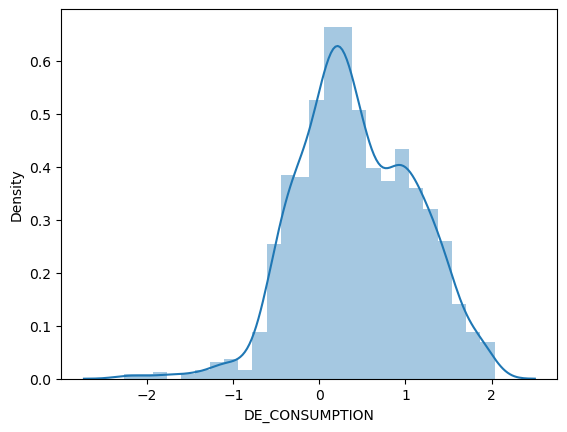

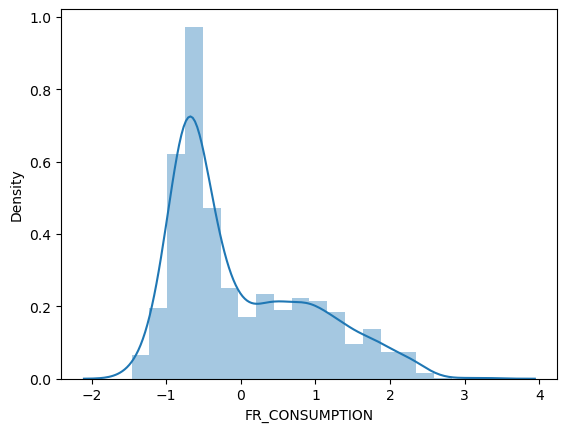

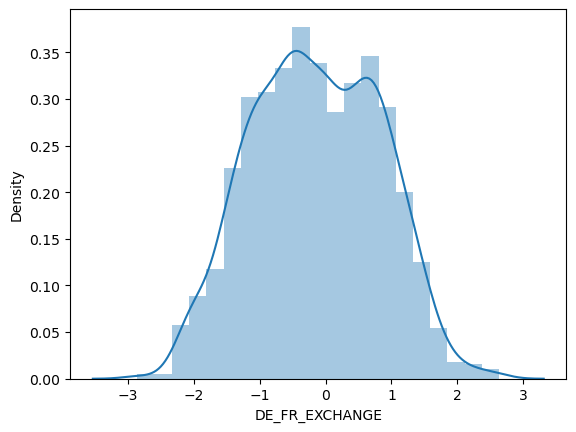

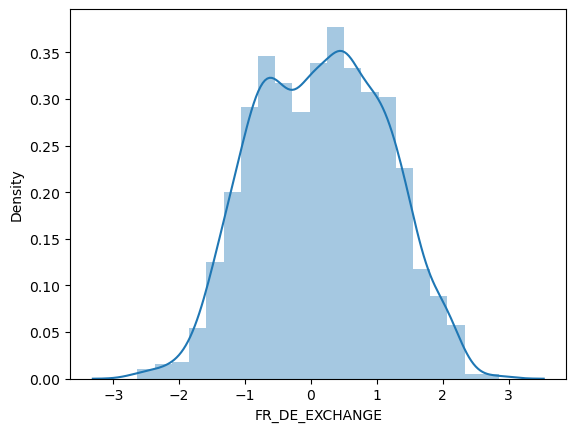

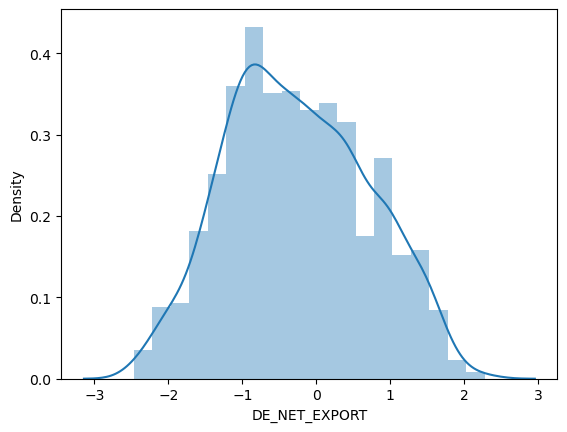

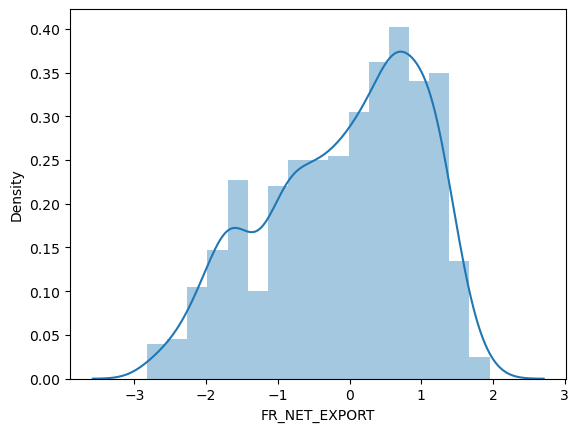

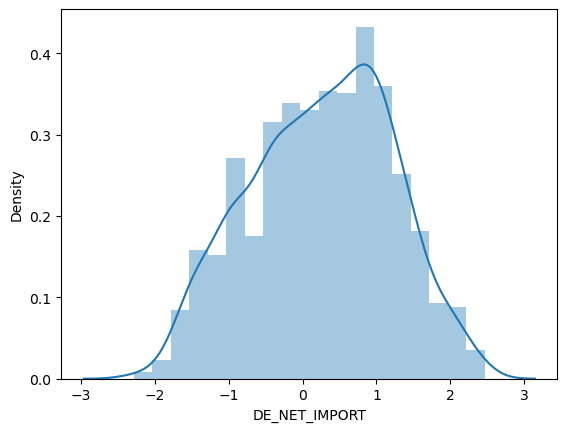

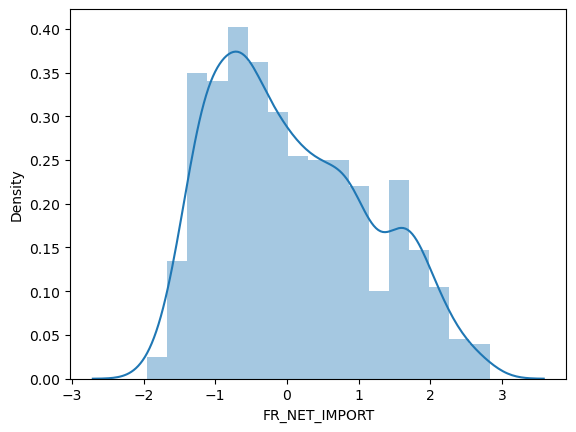

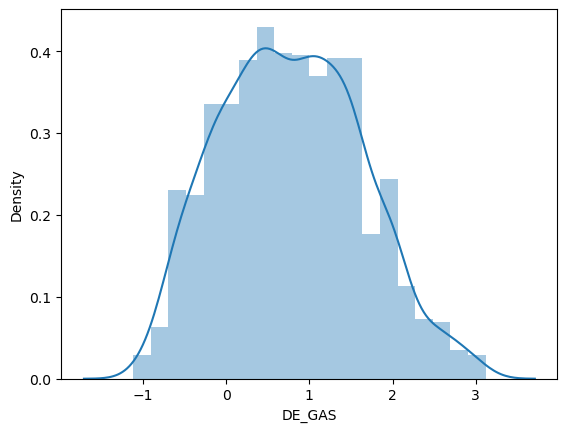

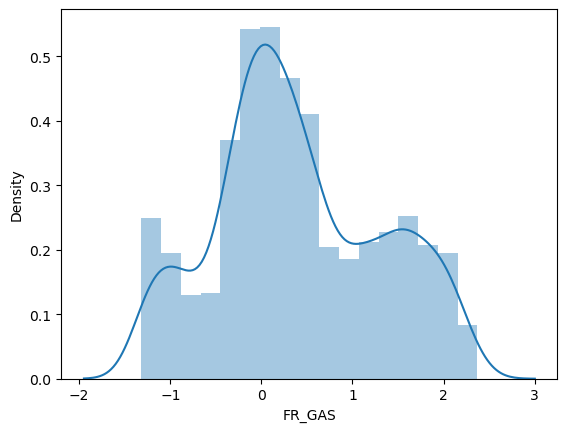

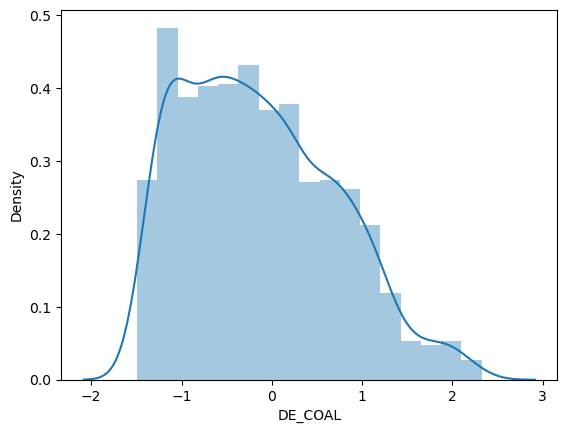

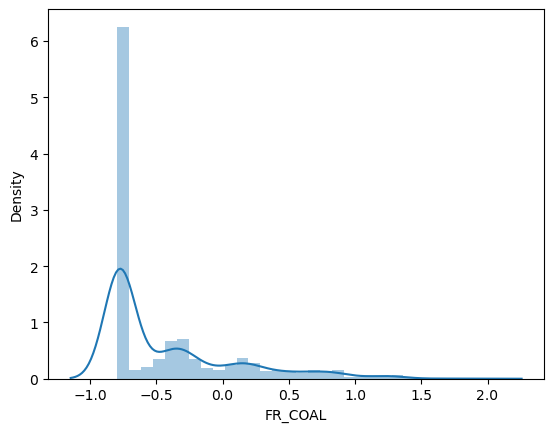

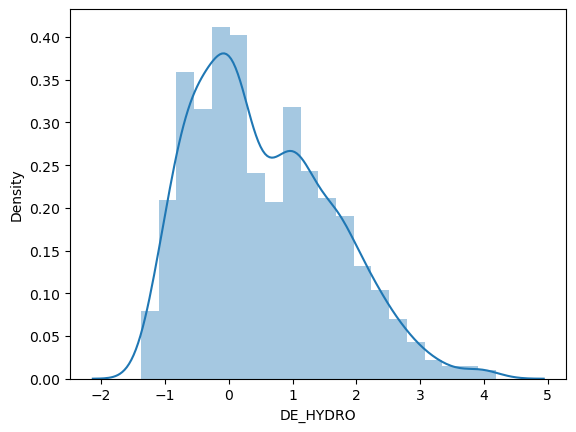

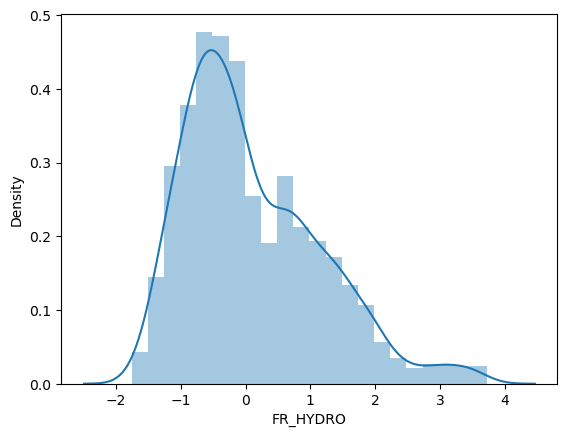

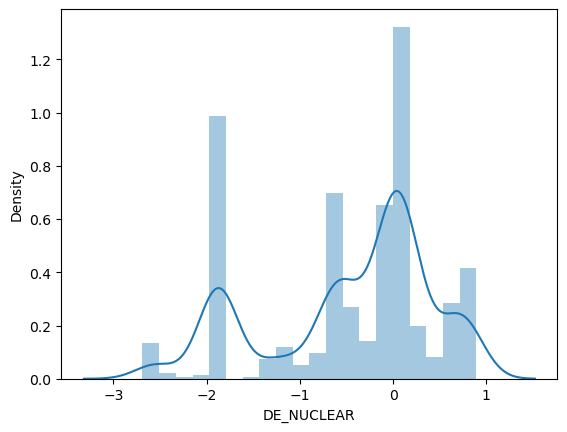

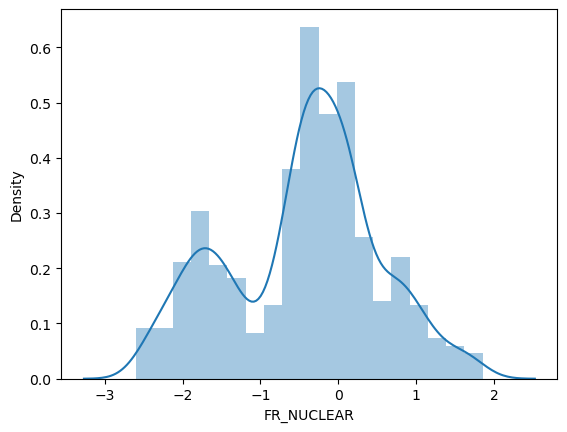

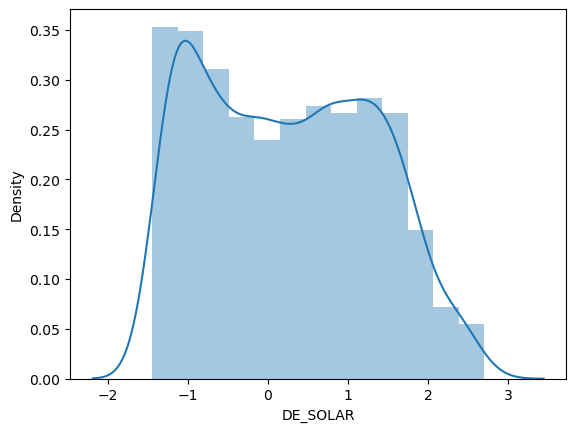

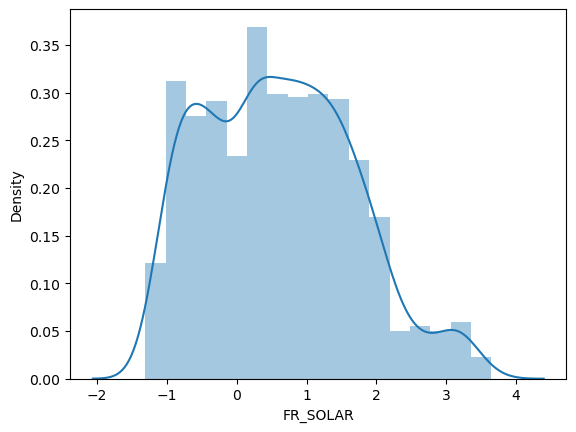

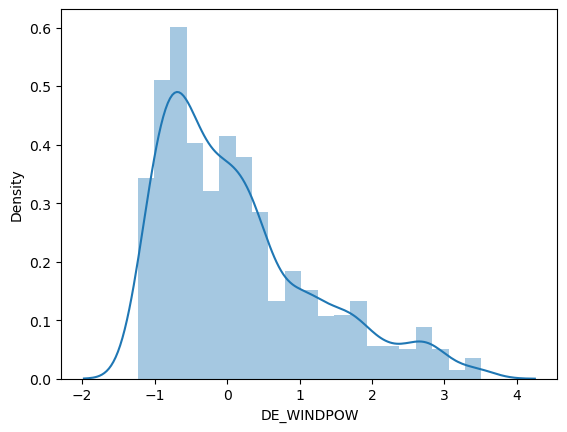

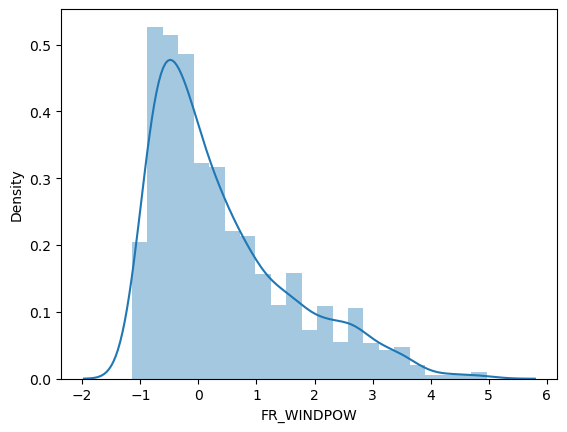

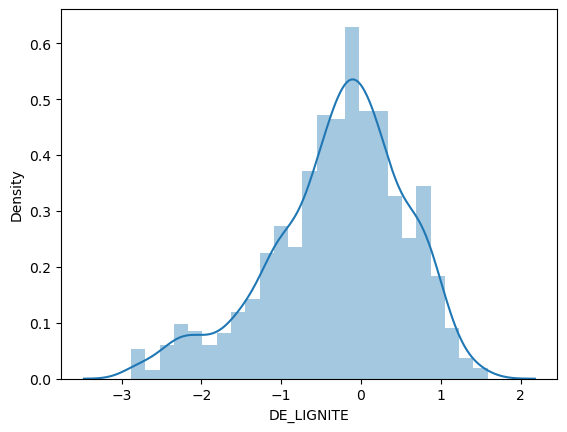

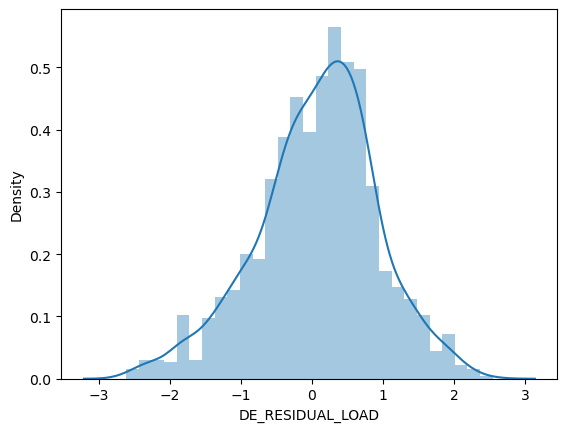

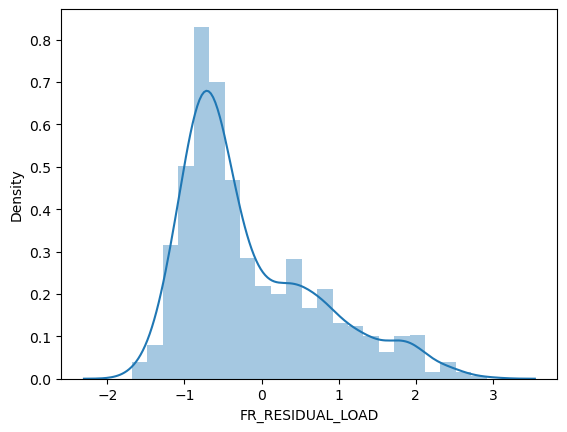

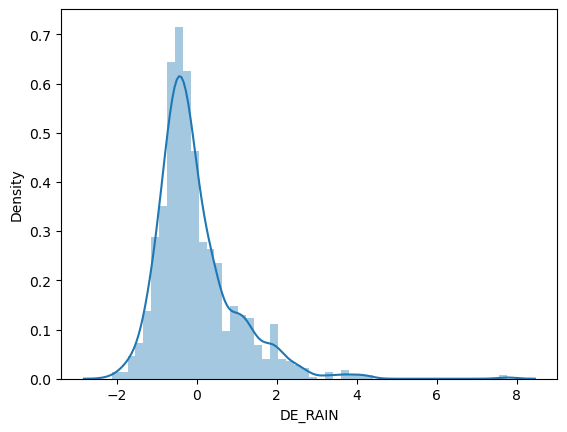

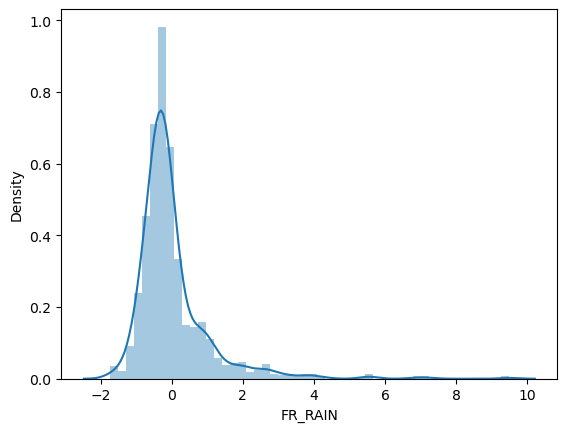

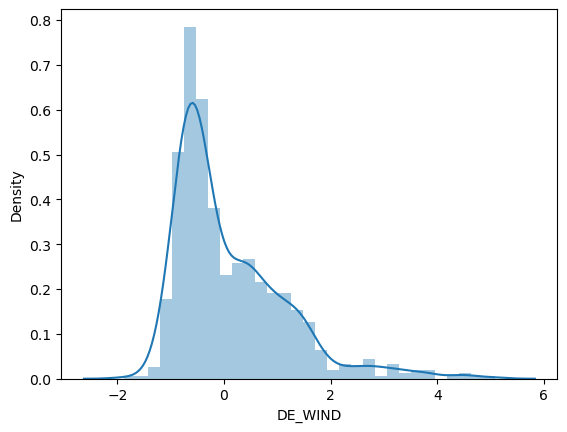

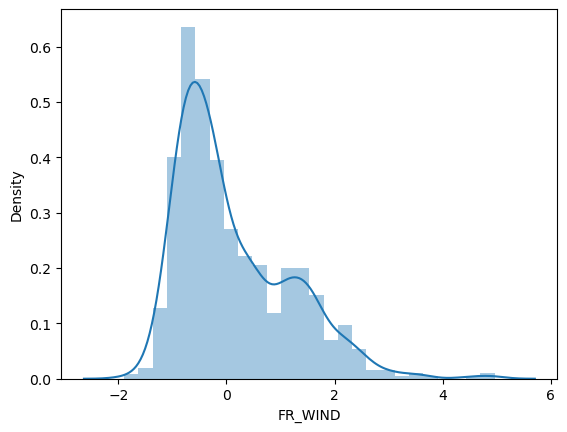

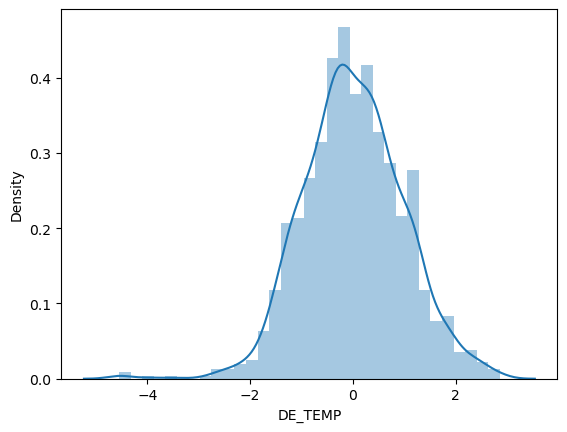

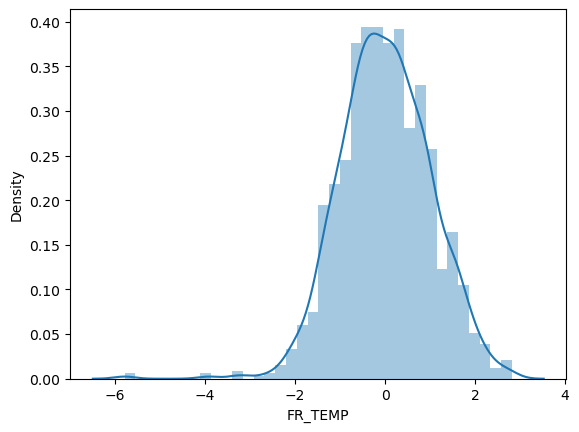

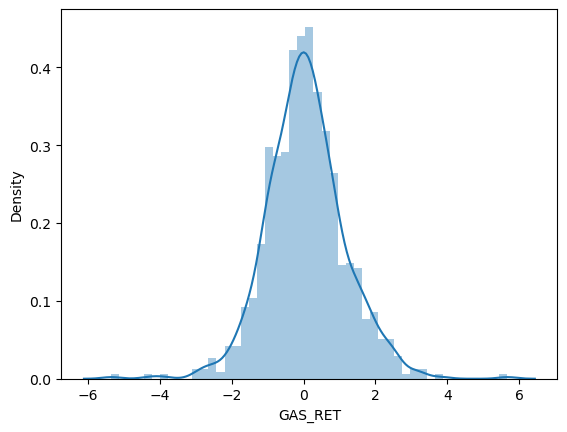

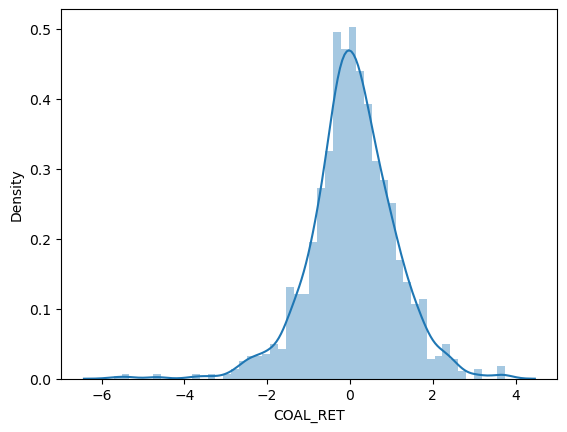

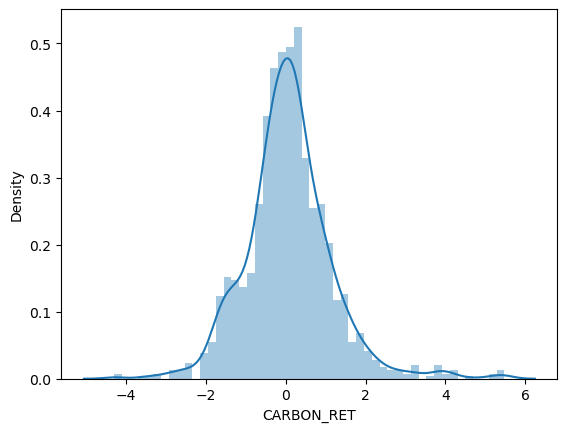

In [37]:
### add code here - fix, make smalller charts
for col in X_train.select_dtypes('float'):
  # print(col)
  plt.figure()
  sns.distplot(X_train[col])

observations here

### Correlation Analysis

We can plot the correlation matrix to see whether any columns are correlated.

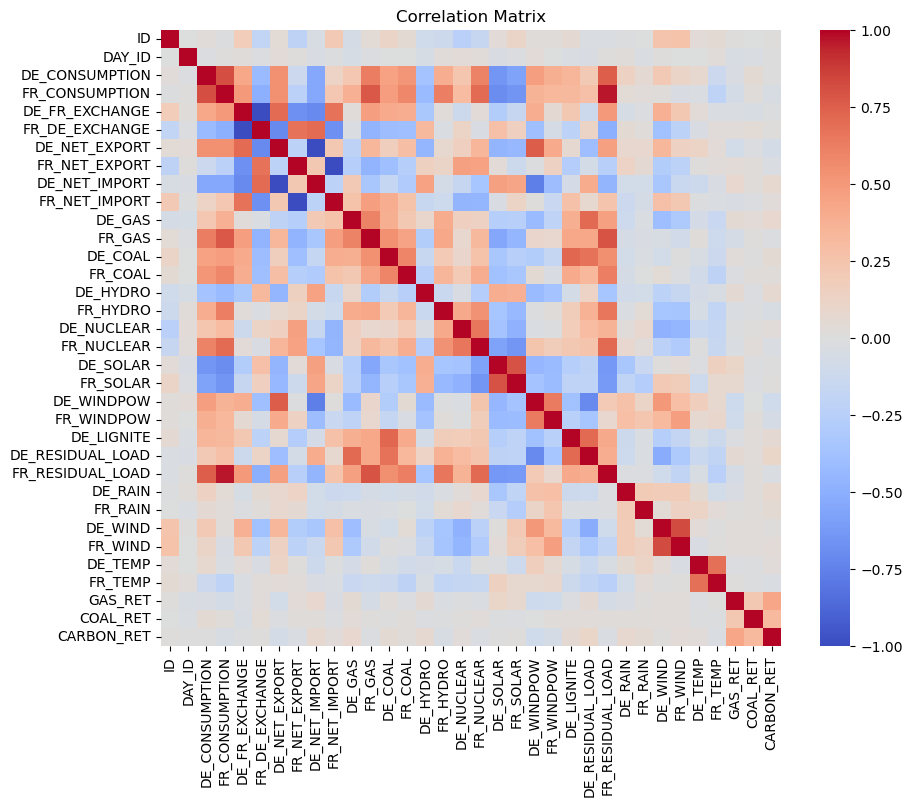

In [38]:
numerical_columns = X_train.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numerical_columns.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

We consider +/-0.8 to be a high correlation. We filter for these correlations below to see which columns are highly correlated.

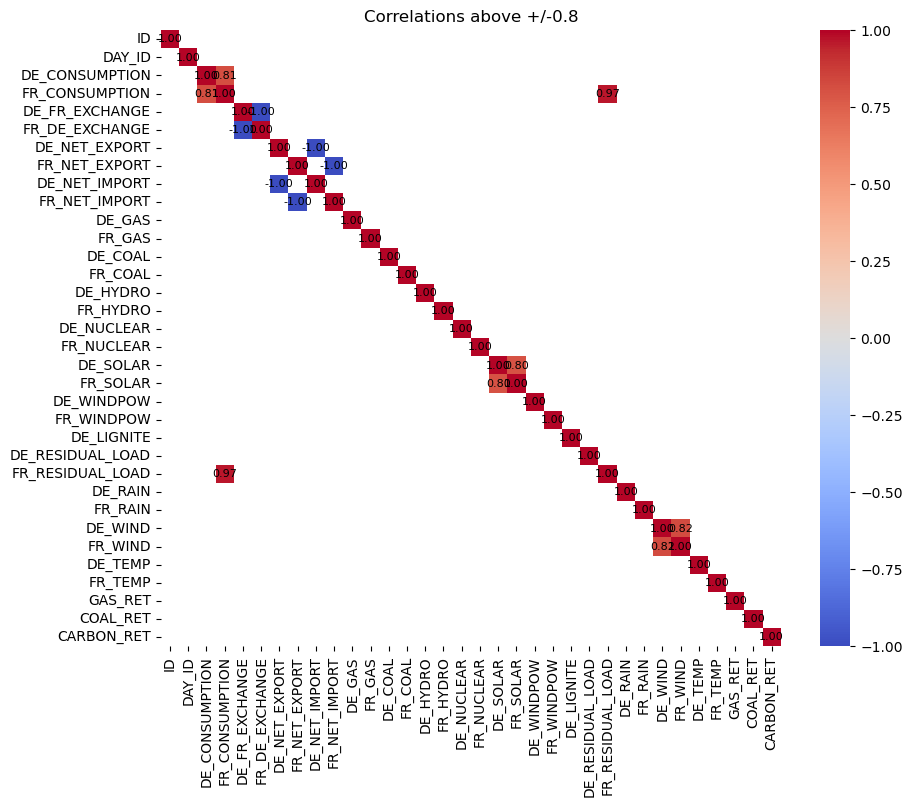

In [39]:
# Filter correlations above 0.8 
high_correlations = correlation_matrix[correlation_matrix.abs() > 0.8]

plt.figure(figsize=(10, 8))
annot_kws = {"ha": 'center', "va": 'center', "fontsize": 8, "color": 'black'}
sns.heatmap(high_correlations, annot=True, cmap='coolwarm', fmt=".2f", annot_kws=annot_kws)
plt.title('Correlations above +/-0.8')
plt.show()

From the correlation plot, we observe the following correlations:
- FR_CONSUMPTION and FR_RESIDUAL_LOAD
- FR_CONSUMPTION and DE_CONSUMPTION 
- DE_FR_EXCHANGE and FR_DE_EXCHANGE
- DE_NET_IMPORT and DE_NET_EXPORT
- FR_NET_IMPORT and FR_NET_EXPORT
- DE_SOLAR and FR_SOLAR
- DE_WIND and FR_WIND

It is likely that we will need to remove some of these columns.

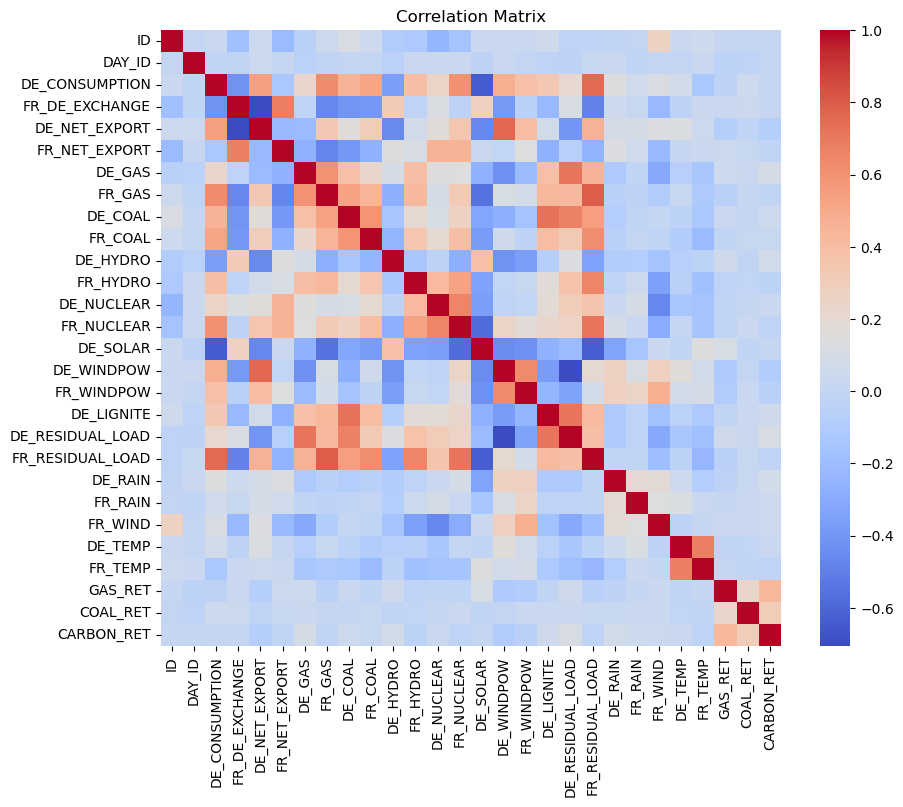

In [40]:
X_train_no_corr = X_train.drop(['COUNTRY', 'FR_CONSUMPTION', 'DE_FR_EXCHANGE', 'DE_NET_IMPORT', 'FR_NET_IMPORT', 'FR_SOLAR', 'DE_WIND'], axis=1)
correlation_matrix = X_train_no_corr.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

There are no more correlations above 0.8 as we can see below.

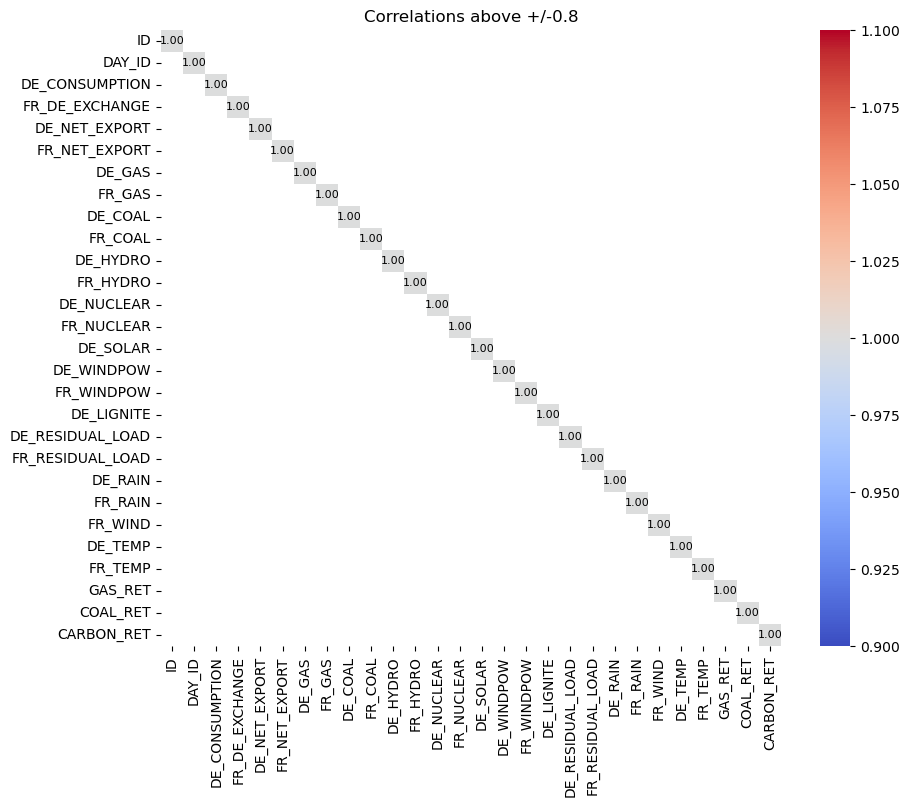

In [41]:
# Filter correlations above 0.8
high_correlations = correlation_matrix[correlation_matrix.abs() > 0.8]

plt.figure(figsize=(10, 8))
annot_kws = {"ha": 'center', "va": 'center', "fontsize": 8, "color": 'black'}
sns.heatmap(high_correlations, annot=True, cmap='coolwarm', fmt=".2f", annot_kws=annot_kws)
plt.title('Correlations above +/-0.8')
plt.show()

### Encoding non-numerical columns

In [118]:
import pandas as pd
import numpy as np
X_train.shape

(1494, 36)

### Missing values

In [43]:
#Count the missing value
X_train.isnull().sum()
#show only the one that is not 0
X_train.isnull().sum()[X_train.isnull().sum() > 0]

DE_FR_EXCHANGE     25
FR_DE_EXCHANGE     25
DE_NET_EXPORT     124
FR_NET_EXPORT      70
DE_NET_IMPORT     124
FR_NET_IMPORT      70
DE_RAIN            94
FR_RAIN            94
DE_WIND            94
FR_WIND            94
DE_TEMP            94
FR_TEMP            94
dtype: int64

- As we can see, there are some numbers are the same amount of missing values
    - DE_FR_EXCHANGE = FR_DE_EXCHANGE
    - DE_NET_EXPORT = - DE_NET_IMPORT
    - FR_NET_EXPORT = - FR_NET_IMPORT

#### We try 3 different methods for missing values and see how this will impact model results.

1. We will remove the rows with missing values.

In [102]:
Xtrain_copy = X_train.copy()
X_train_dropnull = Xtrain_copy.dropna()
print("The new size", X_train_dropnull.shape)

The new size (1276, 36)


2. Replacing the missing value to 0

In [47]:
#fill the missing value with 0
X_train_fillna = Xtrain_copy.fillna(0)

3. Change the null value to moving average for different country

In [117]:
#replace the missing value with running average according to the DAY_ID for fr_df and de_df
fr_df = X_train[X_train['COUNTRY'] == 'FR']
de_df = X_train[X_train['COUNTRY'] == 'DE']

#make an order of the DAY_ID for data with ascending order
fr_df = fr_df.sort_values(by='DAY_ID')
de_df = de_df.sort_values(by='DAY_ID')

def fill_with_running_avg(df):
    return df

france_df_filled = fill_with_running_avg(fr_df)
    
#check the missing value
print('FR missing values:', france_df_filled.isnull().sum().sum())

FR missing values: 720


In [105]:
#merge fr_df and de_df together and creat an binomial for the country for FR =1 and DE = 0 
X_train_merge= pd.concat([fr_df, de_df])
X_train_merge['country_encoded'] = X_train_merge['COUNTRY'].apply(lambda x: 0 if x == 'DE' else 1)
X_train_merge.shape

(1494, 36)

## Model Testing

### Baseline: Linear Regression - gabri

The benchmark for this challenge consists in a simple linear regression, after a light cleaning of the data: The missing (NaN) values are simply filled with 0's and the `COUNTRY` column is dropped - namely we used the same model for France and Germany. 

In [ ]:
lr = LinearRegression()

X_train_clean = X_train.drop(['COUNTRY'], axis=1).fillna(0)
Y_train_clean = Y_train['TARGET']

lr.fit(X_train_clean, Y_train_clean)

output_train = lr.predict(X_train_clean)

def metric_train(output):

    return  spearmanr(output, Y_train_clean).correlation

print('Spearman correlation for the train set: {:.1f}%'.format(100 * metric_train(output_train) ))

Spearman correlation for the train set: 27.8%


The Spearman correlation obtained with our model on the train data set is about 27.9%.

NB: Electricity price variations can be quite volatile and this is why we have chosen the Spearman rank correlation as a robust metric for the challenge, instead of the more standard Pearson correlation.

### Model 1: Decision Trees - rhianne

### Model 2: Bagging - alix

### Model 3: Random Forest - rhianne

### Model 4: Boosting - vivian

### Model 5: Gradient Boosted Trees - gabri

### Model 6: AdaBoost - alix

### Model 7: XGBoost - vivian

I dont think we need the code below.

## Generate the output

Next, we process the test set the same way as we did on the train set and predict using our linear model, while saving the predictions to a csv file satisfying the challenge output contraints.


In [ ]:
X_test.head()

,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
0,1115,241,FR,0.340083,-0.433604,-0.423521,0.423521,0.165333,0.519419,-0.165333,...,-0.222525,-0.513180,-0.182048,-0.982546,-0.876632,0.880491,0.692242,0.569419,-0.029697,-0.929256
1,1202,1214,FR,0.803209,0.780411,0.601610,-0.601610,0.342802,0.555367,-0.342802,...,0.857739,-0.340595,-0.301094,-0.759816,-1.221443,-0.616617,-0.737496,0.251251,0.753646,0.664086
2,1194,1047,FR,0.795540,0.721954,1.179158,-1.179158,1.620928,0.666901,-1.620928,...,0.447967,0.796475,-0.367248,0.376055,-0.483363,0.865138,0.120079,-1.485642,-0.326450,-0.349747
3,1084,1139,FR,0.172555,-0.723427,-0.044539,0.044539,NaN,-0.205276,NaN,...,-0.561295,-0.542606,-0.013291,-0.791119,-0.894309,0.239153,0.457457,-0.746863,2.262654,0.642069
4,1135,842,FR,0.949714,0.420236,0.617391,-0.617391,0.608561,-0.240856,-0.608561,...,0.503567,-0.230291,-0.609203,-0.744986,-1.196282,0.176557,0.312557,-2.219626,-0.509272,-0.488341


In [ ]:
X_test_clean = X_test.drop(['COUNTRY'], axis=1).fillna(0)

Y_test_submission = X_test[['ID']].copy()
Y_test_submission['TARGET'] = lr.predict(X_test_clean)

Y_test_submission.to_csv('benchmark_qrt.csv', index=False)


/Users/vivianwang/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names seen at fit time, yet now missing:
- country_encoded

  warnings.warn(message, FutureWarning)


ValueError: X has 34 features, but LinearRegression is expecting 35 features as input.

After submitting this benchmark_qrt.csv file at https://challengedata.ens.fr, we obtain a public score of around 15.9 % - this is the score to beat!


## Tips and ideas for improvements 

- Thinking about the fundamental price drivers of electricity in each country may be useful. 

- The dataset is small, so you will need to be careful not to overfit your models. It will be useful to use good crossvalidation practices. 
